In [1]:
import networkx as nx
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
from qiskit import transpile

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from collections import defaultdict
from operator import itemgetter

In [2]:
graph_nodes = [[0, 1, 2, 3], 
               [0, 1, 2, 3],
               [0, 1, 2, 3, 4],
               [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]


graph_edges = [[(0, 1), (1, 2), (2, 3), (3, 0)],
               [(0, 1), (1, 2), (2, 3), (3, 0), (1,3)],
               [(0, 1), (1, 2), (2, 3), (3, 0), (2,4), (3,4)],
               [(0,1), (0,2), (1,3), (1,4), (2,3), (3,4), (3,5), (4,5), (4,6), (5,9), (5,8), (5,6), (6,7), (7,10), (8,9), (8,10)]]

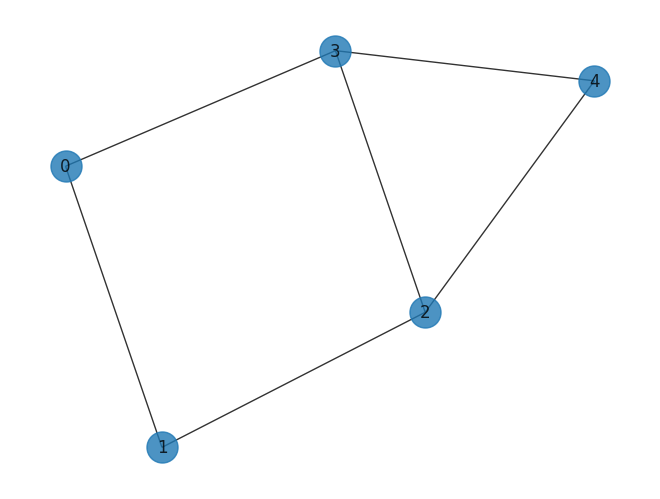

In [122]:
x = 2 # pick which graph we want to use

graph = nx.Graph()
graph.add_nodes_from(graph_nodes[x])
graph.add_edges_from(graph_edges[x])
nx.draw(graph, with_labels=True, alpha=0.8, node_size=500)

In [5]:
#Get weight matrix of graph
adj_matrix = nx.adjacency_matrix(graph)
size = adj_matrix.shape[0]

#Build qubo matrix Q from weight matrix W
weight_matrix = np.zeros((size, size))
for i in range(size):
    for j in range(size):
        weight_matrix[i, j] = adj_matrix[i, j]

print(weight_matrix)

[[0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 0.]
 [0. 1. 0. 1. 1.]
 [1. 0. 1. 0. 1.]
 [0. 0. 1. 1. 0.]]


## Min Cut Optimization problem

$$ \text{maximize } \;\;      x^{\dagger}Qx + c^{\dagger}x$$

Where Q is a n x n matrix representing the weights between nodes \
C is a n-sized vector representing total weights coming from node i \
X is a vector of our decision variables \
    $$ if x_i = -1 \;\;      \text{then } x_i \text{ belongs to partition 1}$$
    $$ if x_i = 1 \;\;      \text{then } x_i \text{ belongs to partition 2}$$

Such that:
$$ \text{minimize } \;\; \sum_{i = 1}^n x_i \text{  (try to make each partition roughly the same size)} $$


### Transform this into an unconstrainted problem

Define the penalty functino as

$$ p(x) = \text{minimize } \;\; \sum_{i = 1}^n x_i$$

New unconstrained cost function:

$$ \text{maximize } \;\;      x^{\dagger}Qx + c^{\dagger}x + \alpha p(x)^2$$

Where $\alpha$ is a scalar penalty parameter


## Constructing the problem Hamiltonian

from the above we can determing the our cost function is:

$$ C(x) = x^{\dagger}Qx + c^{\dagger}x + \alpha p(x)^2 =  \sum_{i,j = 1}^n Q_{ij} x_i x_j + \sum_{i=1}^n c_i x_i$$

Since,

$$ Z_i |x\rangle = (-1)^{Xi} = \frac{I-Z_i}{2}|x\rangle = x_i$$

### Build circuit for the cost cost operator

Cost operator $$e^{-i\gamma_pC} = e^{-i\gamma_p  (\sum_{ij \epsilon \Epsilon} (Z_i Z_j) - \sum_{i = 0}^n (Z_i Z_i))} $$

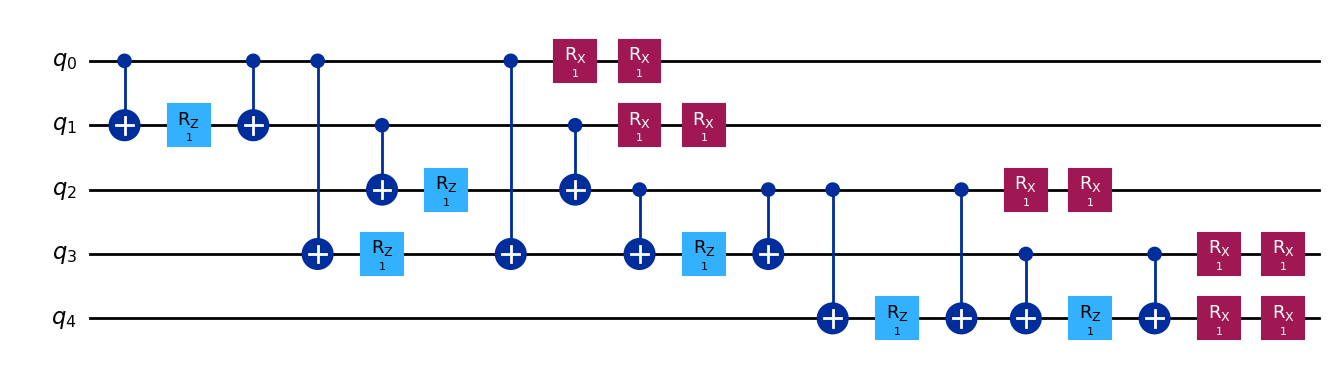

In [123]:
def append_zz_term(qc, q1, q2, gamma):
    qc.cx(q1,q2)
    qc.rz(2*gamma, q2)
    qc.cx(q1,q2)

def get_cost_operator_circuit(g, gamma):
    N = g.number_of_nodes()
    qc = QuantumCircuit(N)
    
    for i,j in g.edges():
        append_zz_term(qc, i, j, gamma)

    for n in g.nodes():
        qc.rx(2*gamma,n)
        qc.rx(2*gamma,n)   

    return qc

get_cost_operator_circuit(graph,0.5).draw('mpl')


The Mixing Unitary

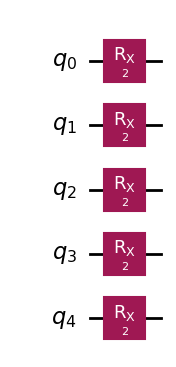

In [124]:
def append_x_term(qc, q1, beta):
    qc.rx(2*beta, q1)

def get_mixer_operator_circuit(g, beta):
    N = g.number_of_nodes()
    qc = QuantumCircuit(N)

    for n in g.nodes():
        append_x_term(qc,n,beta)

    return qc

get_mixer_operator_circuit(graph, 1).draw('mpl')

Now build the full circuit

In [125]:
def get_qaoa_circuit(g, beta, gamma):
   assert(len(beta) == len(gamma)) 
   p = len(beta) #infering number of QAOA steps from the parameters passed
   N = g.number_of_nodes()
   qc = QuantumCircuit(N)

   #put inputs into superposition
   qc.h(range(N))

   #apply alternating operators
   for i in range(p): 
      qc.compose(get_cost_operator_circuit(g,gamma[i]), range(N), inplace=True)
      qc.compose(get_mixer_operator_circuit(g, beta[i]), range(N), inplace=True)

   #perform measurement
   qc.measure_all()

   return qc

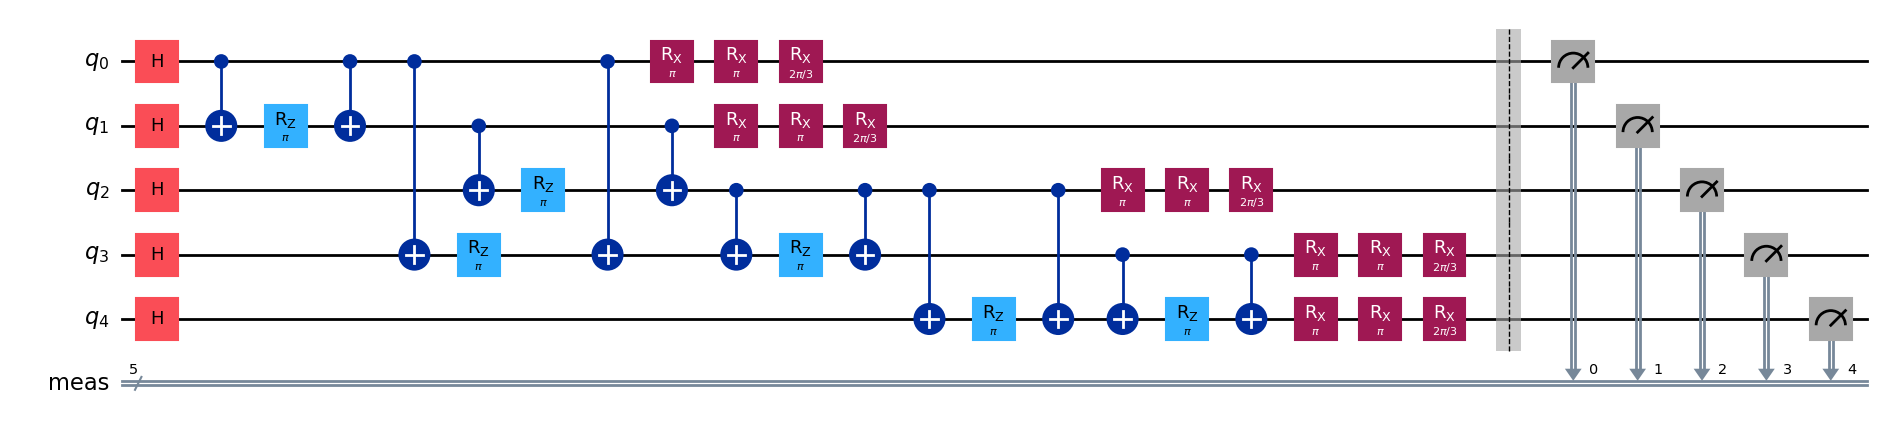

In [126]:
qc = get_qaoa_circuit(graph, [np.pi/3], [np.pi/2])
qc.draw('mpl', fold=False)

Run the circuit on the simulator

In [127]:
backend = AerSimulator()

#transpile
qc_compiled = transpile(qc, backend)

#execute the circuit 
job_sim = backend.run(qc_compiled, shots=1024)

#grab results
result_sim = job_sim.result()
print(result_sim.get_counts())

{'11101': 31, '00010': 33, '01000': 44, '10110': 30, '00111': 41, '01101': 20, '11011': 33, '00110': 23, '01011': 38, '11110': 27, '00011': 20, '10101': 36, '10001': 32, '11001': 41, '01111': 48, '11010': 44, '10010': 37, '11000': 29, '00100': 29, '10100': 24, '10000': 30, '01010': 27, '11100': 27, '01100': 26, '00001': 28, '00101': 26, '01110': 35, '00000': 26, '01001': 31, '10111': 38, '11111': 29, '10011': 41}


How good are these results?

In [128]:
#compute qaoa energy 

def mincut_obj(x,g):
    cut = 0
    for i,j in g.edges():
        if x[i] != x[j]:
            cut -= 1
    #print("Cut is " + str(cut))

    penalty = 0
    for k in x:
        if k == "0":
            penalty -= 1
        else:
            penalty += 1
    #print("Penalty is " + str(penalty**2))

    cost = cut + (penalty**2)
    #print("Total cost is " + str(cost))
    return cost

mincut_obj('00111',graph)
#mincut_obj('00000',graph)


-1

Estimate energy from the sample

In [129]:
def compute_mincut_energy(counts, g):
    energy = 0
    total_counts = 0
    for meas, meas_count in counts.items():
        obj_for_meas = mincut_obj(meas, g)
        energy += obj_for_meas * meas_count
        total_counts += meas_count
    return energy/total_counts

compute_mincut_energy(result_sim.get_counts(), graph)

1.9609375

Put all of this together

In [135]:
def get_black_box_objective(G,p):
    backend = Aer.get_backend('qasm_simulator')
    def f(theta):
        # let's assume first half is betas, second half is gammas
        beta = theta[:p]
        gamma = theta[p:]
        qc = get_qaoa_circuit(G,beta, gamma)        
        qc_compiled = transpile(qc, backend) #transpile 
        counts = backend.run(qc_compiled, shots=2048).result().get_counts() #execute the circuit
        # return the energy
        return compute_mincut_energy(counts, G)
    return f

Run the classical optimization

In [136]:
# p is the number of QAOA alternating operators
p = 5
obj = get_black_box_objective(graph, p)

init_point = np.array([0.81069872, 2.2067517 , 0.83830696, 2.15579759, 0.37060699,
       2.42068091, 6.1575306 , 2.2453419 , 3.85060091, 6.137845  ])
# We are going to limit the number of iterations to 2500
res_sample = minimize(obj, init_point, method='COBYLA', options={'maxiter':2500, 'disp': True})
res_sample

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.779296875
       x: [ 1.783e+00  2.188e+00  7.996e-01  2.252e+00  2.497e-01
            2.412e+00  6.094e+00  2.179e+00  3.838e+00  6.159e+00]
    nfev: 97
   maxcv: 0.0

Now that we have optimized parameters, rerun quantum circuit to get solution

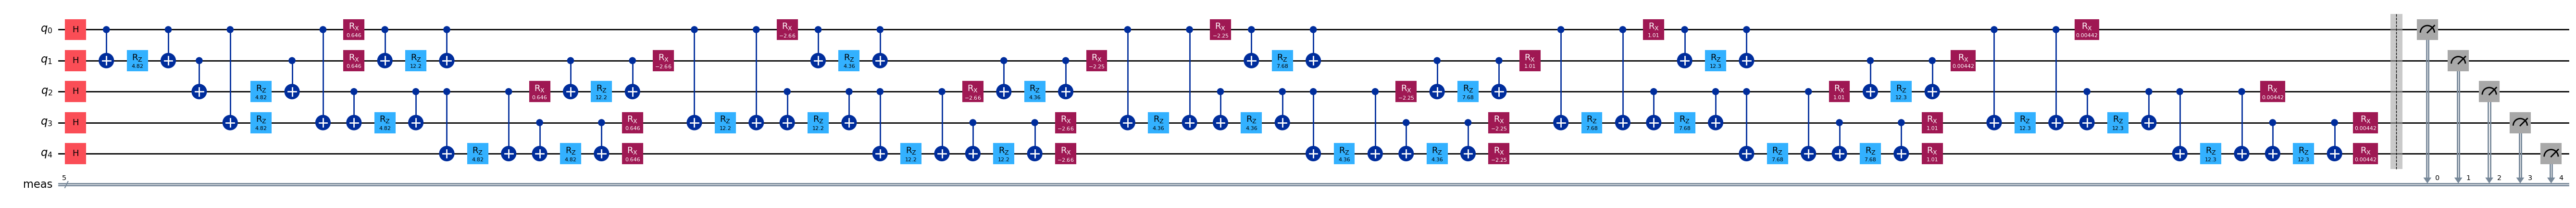

In [137]:
optimal_theta = res_sample['x']
qc = get_qaoa_circuit(graph, optimal_theta[:p], optimal_theta[p:])
qc_compiled = transpile(qc, backend) #transpile 

#show optimized circuit
qc_compiled.draw('mpl', fold=False)

In [138]:
job_sim = backend.run(qc_compiled, shots=1024) #execute the circuit
counts = job_sim.result().get_counts() #extract results
counts


{'10011': 45,
 '11100': 223,
 '01010': 97,
 '01111': 23,
 '01100': 55,
 '10101': 85,
 '10001': 17,
 '00101': 80,
 '00011': 205,
 '00110': 3,
 '11010': 78,
 '01110': 15,
 '10110': 7,
 '01011': 5,
 '00001': 7,
 '10100': 8,
 '11000': 5,
 '01101': 18,
 '00111': 6,
 '11001': 2,
 '10000': 11,
 '01001': 3,
 '00010': 5,
 '01000': 2,
 '10010': 7,
 '11110': 6,
 '00100': 1,
 '11101': 4,
 '10111': 1}

In [139]:
# determine most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

#qiskit reverses the order of nodes so that qubit 0 is the LSB, need to flip to align with our graph nodes
def reverse_bits(x):
  return x[::-1]

best_solution = max(counts, key=counts.get)
best_solution = reverse_bits(best_solution)

print("Resulting bitstring:", best_solution)

#values = np.abs(list(counts.values()))
#top_value = sorted(values, reverse=True)[:1]
#print(top_value)



Resulting bitstring: 00111


C:\Users\Ed\AppData\Local\Temp\ipykernel_23028\34689554.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.get_children()[int(p)].set_color("tab:purple")


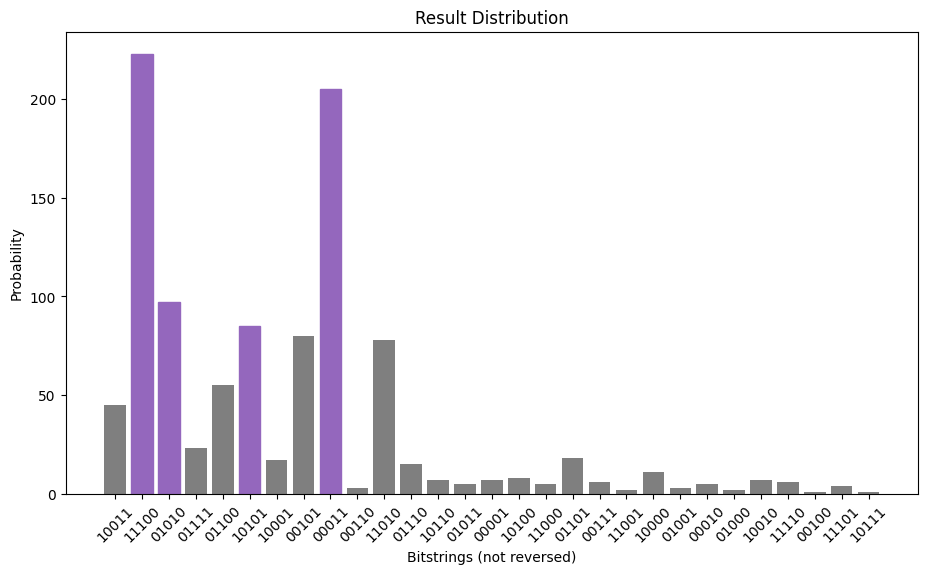

In [140]:
#show distribution
matplotlib.rcParams.update({"font.size": 10})
final_bits = counts
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]

positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])

fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (not reversed)")
plt.ylabel("Probability")

ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
    
plt.show()

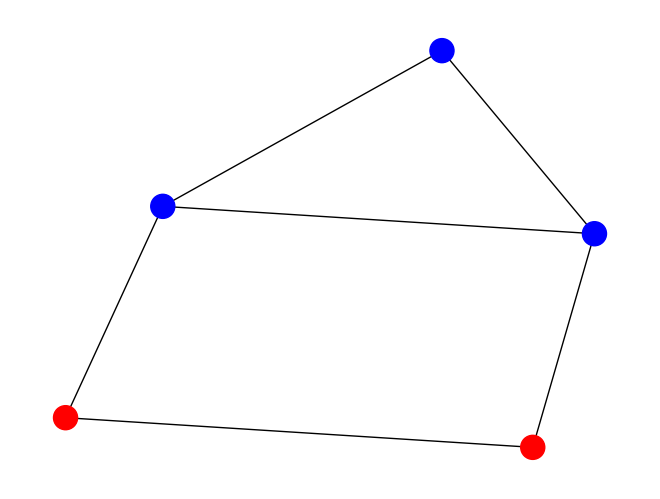

In [141]:
# color the graph nodes by part
colors = ['r' if best_solution[node] == '0' else 'b' for node in graph]
nx.draw(graph,node_color = colors) 

### Try a bigger graph

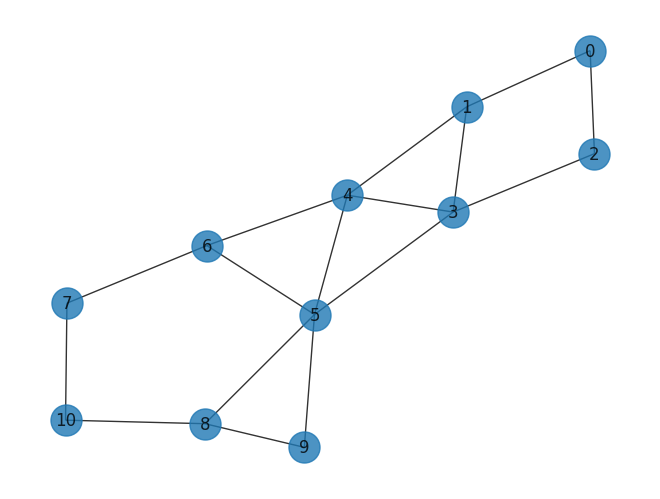

In [142]:
x = 3 # pick which graph we want to use

bigger_graph = nx.Graph()
bigger_graph.add_nodes_from(graph_nodes[x])
bigger_graph.add_edges_from(graph_edges[x])
nx.draw(bigger_graph, with_labels=True, alpha=0.8, node_size=500)

Construct Circuit

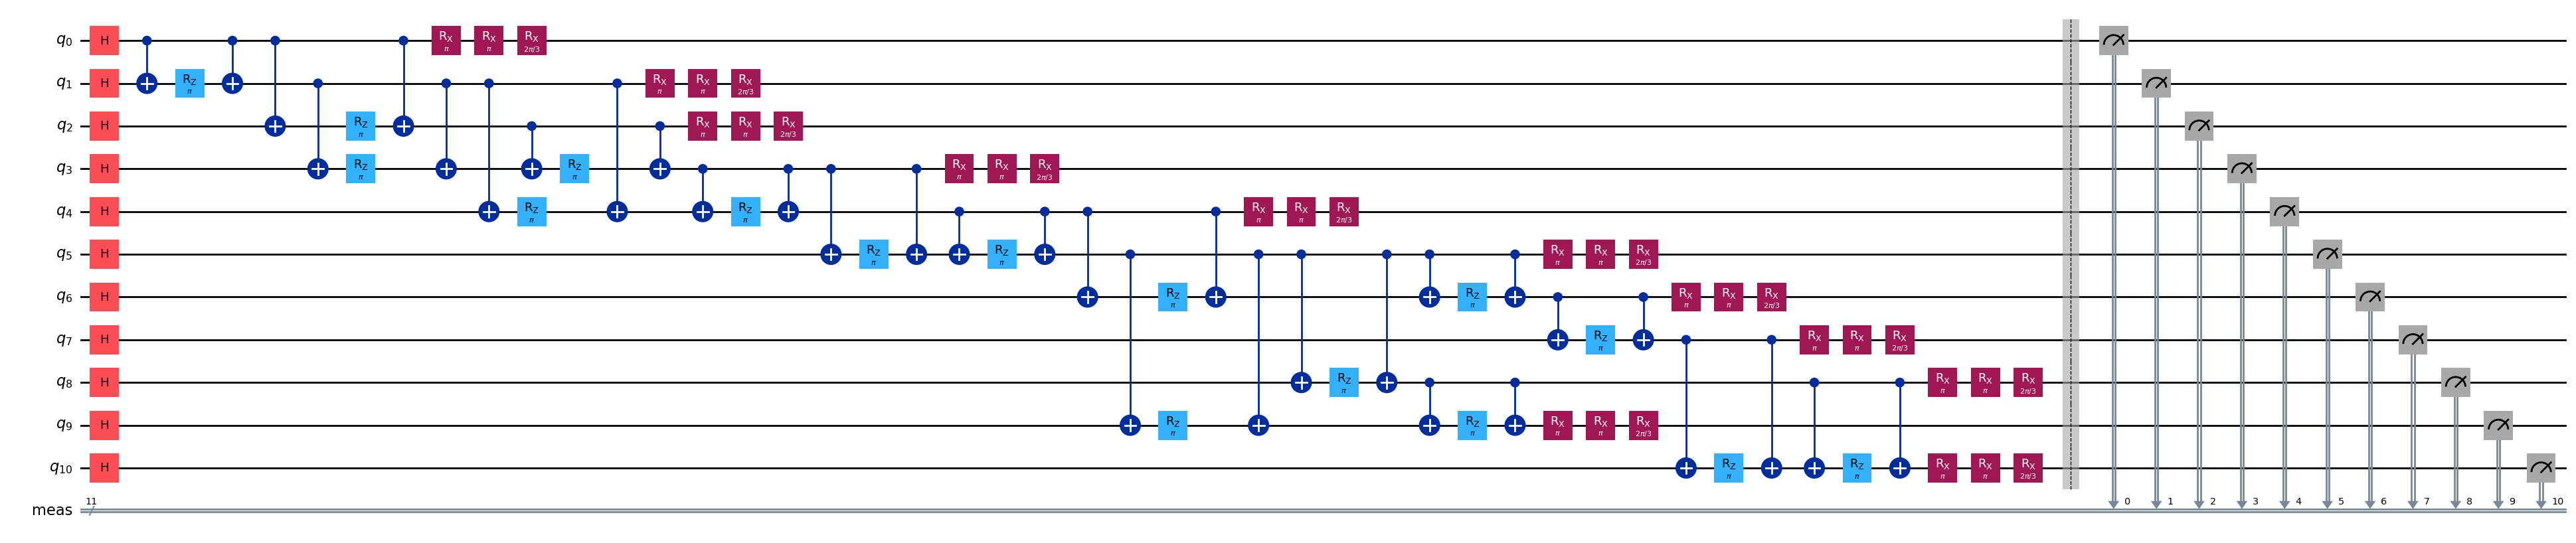

In [143]:
qc1 = get_qaoa_circuit(bigger_graph, [np.pi/3], [np.pi/2])
qc1.draw('mpl', fold=False)

Run the circuit on the simulator

In [144]:
backend = AerSimulator()

#transpile
qc1_compiled = transpile(qc1, backend)

#execute the circuit 
job_sim = backend.run(qc1_compiled, shots=1024)

#grab results
result_sim = job_sim.result()
print(result_sim.get_counts())

{'01010010110': 1, '11010111100': 3, '01010001110': 3, '01111100111': 1, '01011101011': 3, '01000100111': 3, '10100000010': 1, '11001011111': 2, '10101011101': 2, '11000110101': 1, '10101000111': 2, '10101111111': 2, '00110111001': 1, '11001001101': 1, '01111000000': 1, '11110100110': 1, '00001110101': 2, '01100001110': 1, '01110110011': 1, '01001010011': 1, '00000000110': 1, '01101011111': 1, '00111001110': 1, '10110101100': 1, '10001011111': 1, '00110101100': 2, '01111010110': 1, '01110111101': 3, '01000110110': 1, '10010110111': 1, '01101000101': 1, '00000000010': 1, '11011100011': 3, '01010111011': 1, '01011000101': 1, '10000100100': 4, '01101011011': 1, '00101101101': 3, '11011011111': 2, '01011000011': 1, '01101011101': 1, '10000100010': 3, '11011100101': 1, '00000000100': 2, '01010111101': 2, '10011101100': 1, '11101100001': 1, '00010111010': 3, '11101010110': 1, '00111111010': 1, '10110111001': 2, '10101010010': 2, '10000110111': 1, '01010000000': 2, '11100011011': 2, '10101011

Run the classical optimization for quantum parameters

In [145]:
# p is the number of QAOA alternating operators
p = 5
obj = get_black_box_objective(bigger_graph, p)

init_point = np.array([0.81069872, 2.2067517 , 0.83830696, 2.15579759, 0.37060699,
       2.42068091, 6.1575306 , 2.2453419 , 3.85060091, 6.137845  ])

# We are going to limit the number of iterations to 2500
res_sample = minimize(obj, init_point, method='COBYLA', options={'maxiter':2500, 'disp': True})
res_sample

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5.43603515625
       x: [ 1.927e+00  3.366e+00  7.406e-01  2.176e+00  1.426e+00
            2.152e+00  6.087e+00  1.560e+00  3.129e+00  7.112e+00]
    nfev: 98
   maxcv: 0.0

Reconstruct QAOA circuit with optimal parameters

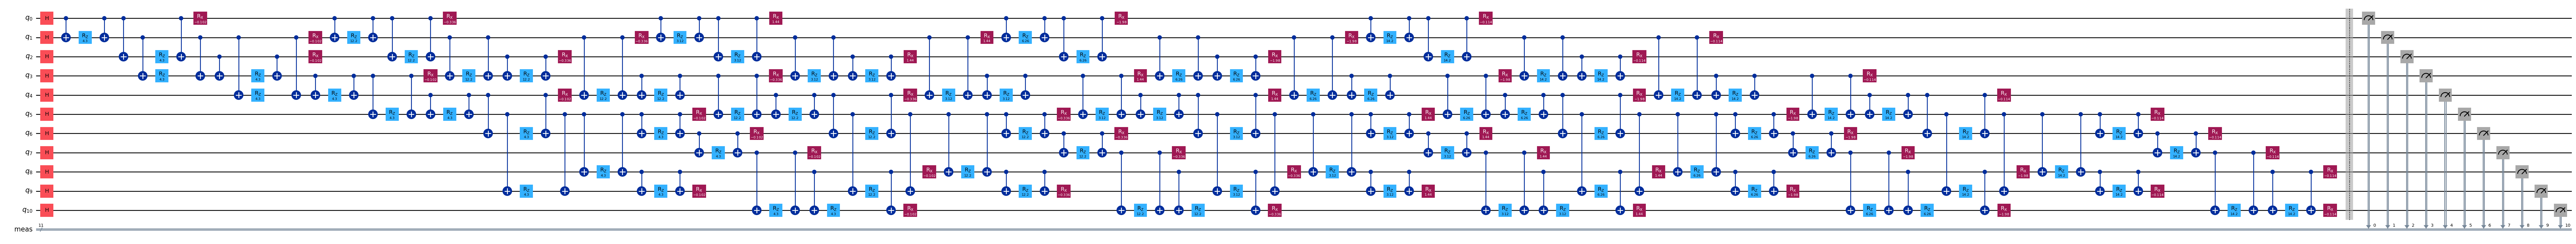

In [146]:
optimal_theta = res_sample['x']
qc1 = get_qaoa_circuit(bigger_graph, optimal_theta[:p], optimal_theta[p:])
qc1_compiled = transpile(qc1, backend) #transpile 

#show optimized circuit
qc1_compiled.draw('mpl', fold=False)

Run the optimized ciruit on the simulator

In [147]:
#qc1_compiled = transpile(qc1, backend)

#Execute the circuit and extract the results
job_sim = backend.run(qc1_compiled, shots=1024) 
counts = job_sim.result().get_counts()
counts


{'11010000101': 3,
 '10000110110': 2,
 '01010011011': 1,
 '10101011001': 2,
 '11010110111': 1,
 '10110101110': 1,
 '00110011001': 11,
 '00111011101': 1,
 '00110110110': 11,
 '01101011001': 3,
 '01010111001': 2,
 '00111011001': 4,
 '10101110100': 2,
 '11001000110': 8,
 '11001011001': 7,
 '10101001010': 2,
 '10101010010': 1,
 '00011110100': 1,
 '01001000110': 1,
 '01111000110': 2,
 '11001001011': 5,
 '00100001010': 1,
 '00100010010': 1,
 '11010111100': 1,
 '01010010110': 7,
 '01010001110': 1,
 '10100011010': 1,
 '11010000001': 2,
 '00101011001': 7,
 '11001010110': 9,
 '11011011100': 1,
 '00010101000': 1,
 '11010011101': 5,
 '01101000110': 5,
 '10010000101': 1,
 '00110001101': 2,
 '01011111010': 1,
 '10001110100': 1,
 '00101100110': 12,
 '00111001010': 4,
 '00010110110': 1,
 '00101111011': 2,
 '10001110110': 1,
 '00101100100': 5,
 '00110110100': 4,
 '10100111110': 2,
 '10001100011': 7,
 '01101101101': 1,
 '11000101001': 1,
 '01010101101': 2,
 '11001100101': 2,
 '00111110110': 2,
 '0011011

Find the best solution

In [148]:
best_solution = max(counts, key=counts.get)
best_solution = reverse_bits(best_solution)

print("Resulting bitstring:", best_solution)

Resulting bitstring: 01100101100


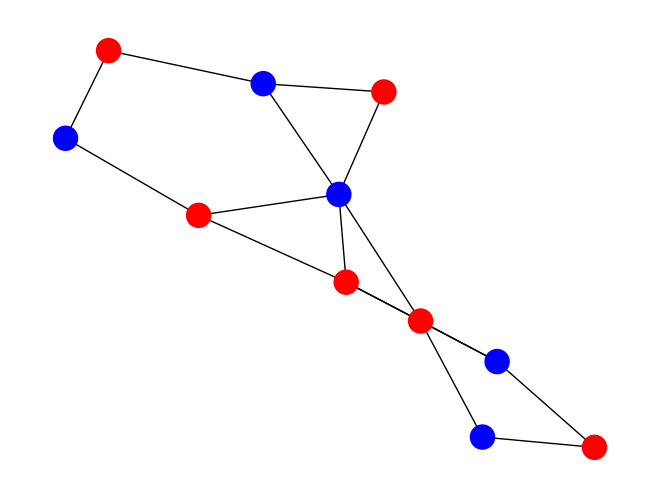

In [149]:
# color the graph nodes by part
colors = ['r' if best_solution[node] == '0' else 'b' for node in bigger_graph]
nx.draw(bigger_graph, node_color = colors) 

## Trivial, but large, graph

Size of A: 10
Size of B: 10
Total size should be: 20


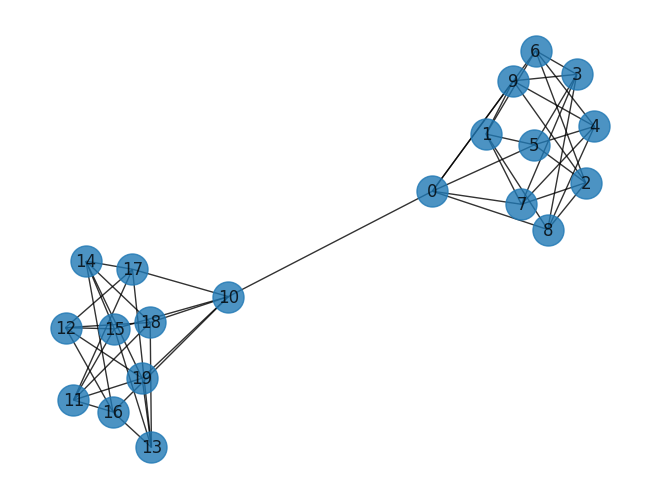

In [150]:
graph_a = nx.complete_bipartite_graph(5,5)
size_a = graph_a.order()
#nx.draw(graph_a, with_labels=True, alpha=0.8, node_size=500)
print("Size of A: " + str(size_a))

graph_b = nx.complete_bipartite_graph(5,5)
size_b = graph_b.order()
print("Size of B: " + str(size_b))
#nx.draw(graph_b, with_labels=True, alpha=0.8, node_size=500)

print("Total size should be: " + str(size_a + size_b))

graph_c = nx.Graph()
graph_c.add_nodes_from(range(size_a + size_b))

graph_c.add_edges_from(graph_a.edges(data=True))

for i,j in graph_b.edges():
    graph_c.add_edge(i+size_a, j+size_a)

graph_c.add_edge(0, size_a) #make single edge connecting the two graphs

nx.draw(graph_c, with_labels=True, alpha=0.8, node_size=500)

Construct Circuit

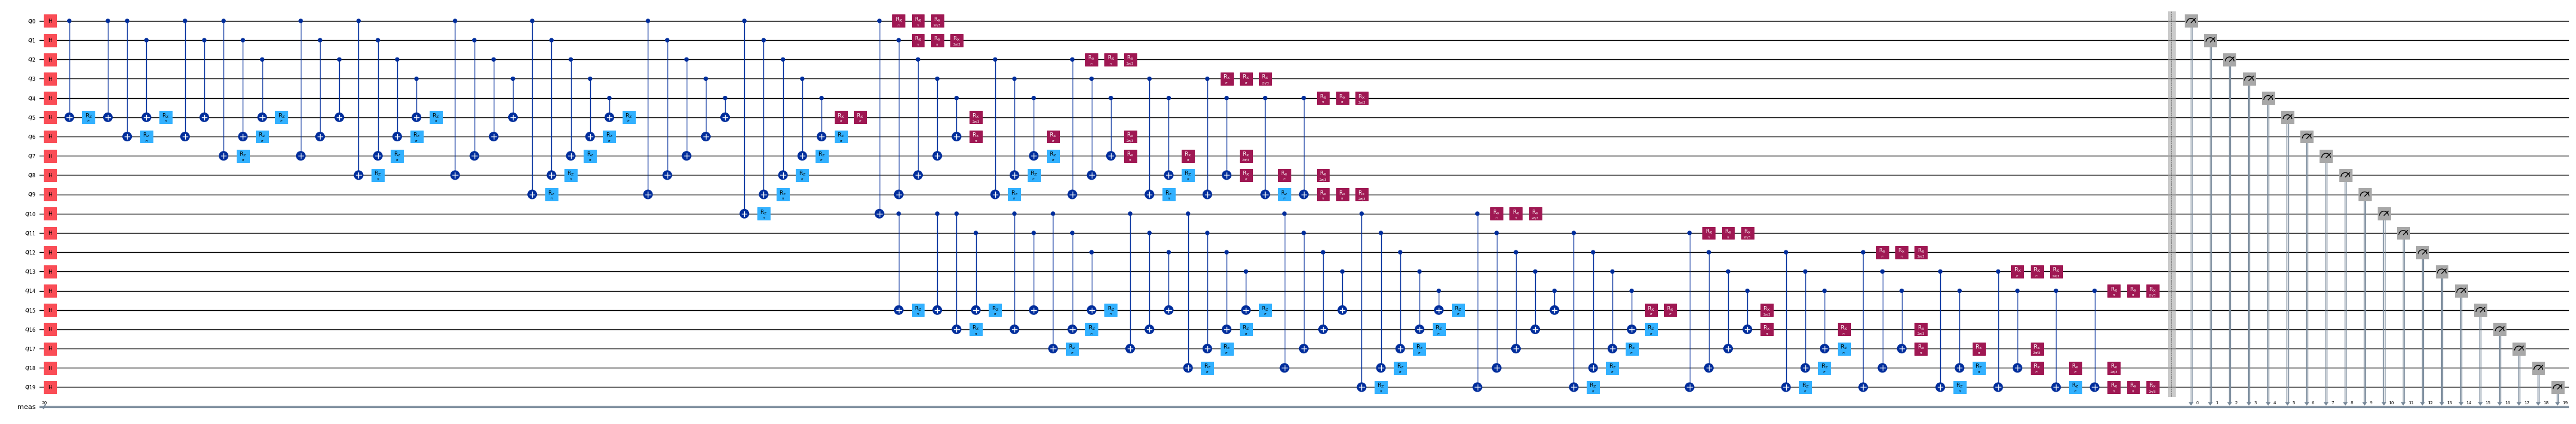

In [164]:
qcT = get_qaoa_circuit(graph_c, [np.pi/3], [np.pi/2])
qcT.draw('mpl', scale = 0.5, fold=False)

Run unoptimized QAOA circuit on simulator

In [152]:
qcT_compiled = transpile(qcT, backend)

#execute the circuit 
job_sim = backend.run(qcT_compiled, shots=1024)

#grab results
result_sim = job_sim.result()
print(result_sim.get_counts())

{'11110110011000110000': 1, '00111011100111110001': 1, '10011101011000000000': 1, '01111010001101001101': 1, '11000111011101011010': 1, '10101011101001111101': 1, '10111100101001011011': 1, '01100011100110010010': 1, '10101110101010110001': 1, '10000001001010110011': 1, '11000111001111111100': 1, '00101011000011011101': 1, '00011111111100110100': 1, '01110000000000101001': 1, '00100110010101011111': 1, '01001100011111011111': 1, '00010010001001000001': 1, '10001001101000110011': 1, '01110100010000110111': 1, '11001100111111110011': 1, '00110010101100110111': 1, '11100001011101011100': 1, '10110001100001010011': 1, '01010110110011110111': 1, '00001110001011101010': 1, '00101000001111101100': 1, '11110101100010110010': 1, '01110100011111010101': 1, '10000010111010010101': 1, '01100010111111011100': 1, '11101111101111111111': 1, '01100111001000110101': 1, '00010001111110101011': 1, '10110011111111001001': 1, '11000100010011111000': 1, '10010110011010100001': 1, '11011001000001101111': 1, 

Run the classical optimization for quantum parameters

In [154]:
# p is the number of QAOA alternating operators
p = size_a + size_b
obj = get_black_box_objective(graph_c, p)

#init_point = np.array([0.81069872, 2.2067517 , 0.83830696, 2.15579759, 0.37060699,
#       2.42068091, 6.1575306 , 2.2453419 , 3.85060091, 6.137845  ])

init_point = np.ones(p*2)

# We are going to limit the number of iterations to 2500
res_sample = minimize(obj, init_point, method='COBYLA', options={'maxiter':2500, 'disp': True})
res_sample

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -12.4462890625
       x: [ 1.004e+00  9.666e-01 ...  9.972e-01  9.771e-01]
    nfev: 351
   maxcv: 0.0

Reconstruct circuit with optimized parameters

In [165]:
optimal_theta = res_sample['x']
qcTO = get_qaoa_circuit(graph_c, optimal_theta[:p], optimal_theta[p:])
qcTO = transpile(qcTO, backend) #transpile 

#show optimized circuit
#qcT_compiled.draw('mpl', fold=False)

Run the circuit 

In [169]:
#Execute the circuit and extract the results
job_sim = backend.run(qcTO, shots=1024) 
counts = job_sim.result().get_counts()

Find best cut

In [170]:
best_solution = max(counts, key=counts.get)
best_solution = reverse_bits(best_solution)

print("Resulting bitstring:", best_solution)

Resulting bitstring: 11111000001111100000


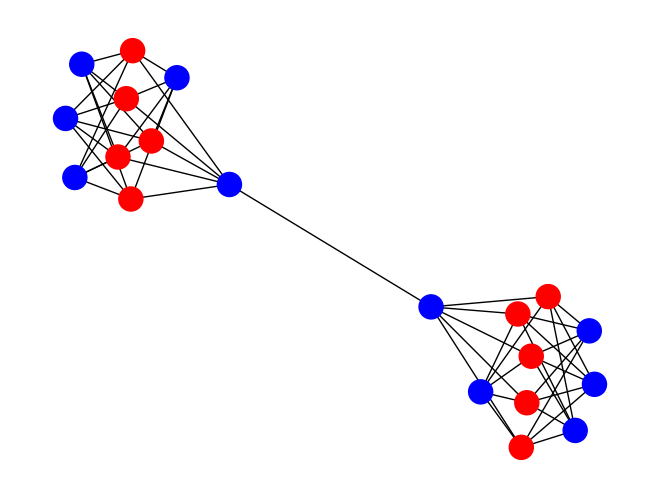

In [171]:
# color the graph nodes by part
colors = ['r' if best_solution[node] == '0' else 'b' for node in graph_c]
nx.draw(graph_c, node_color = colors) 

## Qiskit Version Info

In [48]:
import qiskit
qiskit.version.get_version_info()

'1.1.0'

In [49]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

'0.23.0'